In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split, TensorDataset, DataLoader, Subset
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import copy
import torchvision.transforms as T


import torch.nn.functional as F
from torchvision import datasets, transforms


In [2]:
repo_root = Path().resolve().parents[0]   # parent of "notebooks"
sys.path.insert(0, str(repo_root / "src"))

from fisher_information.fim import FisherInformationMatrix
from models.image_classification_models import *
from models.train_test import *
from prunning_methods.LTH import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
repo_root

WindowsPath('D:/Mestrado/Fisher Information & Lottery Ticket/LTH-FisherInformation')

In [61]:
import os
os.chdir(repo_root)
output_dict_MNIST = torch.load("results\LTH_mnist_convmodel.pth")
output_dict_CIFAR10_resnet18 = torch.load("results\LTH_cifar10_resnet18_1.pth")
output_dict_MNIST_NGD = torch.load("results_NGD\LTH_NGD_mnist_convmodel.pth")
output_dict_CIFAR10_resnet18_NGD = torch.load("results_NGD\LTH_NGD_cifar10_resnet18.pth")

C:\Users\WINDOWS\AppData\Local\Temp\ipykernel_1700\981465505.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  output_dict_MNIST = torch.load("results\LTH_mnist_convmodel.

In [23]:
def make_logdet_per_dim_dict(output_dict, n_layers=1):
    logdet_per_dim_dict = {i: [] for i in range(n_layers)}
    for i in range(100, 0, -10):
        #print(f"Remaining weights {i}, Acc = {output_dict[i][0][0]:.2f}, LogDet/Dim = {output_dict[i][0][-1]:.2f}")
        if n_layers == 1:
            logdet_per_dim_dict[0].append(output_dict[i][0][-1])
        else:
            for j, (key, value) in enumerate(output_dict[i][0][-1].items()):
                logdet_per_dim_dict[j].append(value)  
    return logdet_per_dim_dict

In [30]:
CIFAR10_resnet_logdet_per_dim_dict = make_logdet_per_dim_dict(output_dict_CIFAR10_resnet18, n_layers=5)

In [31]:
CIFAR10_resnet_logdet_per_dim_dict

{0: [4.391796875,
  4.104724994852501,
  3.514087461760707,
  3.878582733142555,
  3.5654722230017963,
  3.4291425760271212,
  3.221755744795179,
  2.5962899267146016,
  1.6894748263888888,
  1.0430154418945312],
 1: [4.531219829776423,
  3.4486239904277594,
  2.984973284087088,
  3.4150991063660094,
  3.170505762209037,
  3.1581073063676075,
  3.043509872645548,
  2.511014665876116,
  1.6280613949424343,
  0.9849449793497721],
 2: [4.695767964515583,
  3.2615391724693024,
  3.107235677083333,
  3.5596864281631095,
  3.1711791937861595,
  3.3038235976813435,
  2.9478306594899664,
  2.4474541888973578,
  1.550560693027211,
  1.037336825046079],
 3: [4.562241700542005,
  2.993773310352622,
  3.1014865928100708,
  3.4779444781553397,
  3.2809021352063708,
  3.2691251314603367,
  2.8634094360596194,
  2.3955104051438054,
  1.537605964700589,
  0.8520203441931893],
 4: [4.479248179200542,
  3.6103077300891644,
  3.7238244060268615,
  4.103928117048346,
  3.8548279714987435,
  3.884405810466

In [28]:
MNIST_logdet_per_dim_dict = make_logdet_per_dim_dict(output_dict_MNIST, n_layers=1)

In [11]:
logdetdim_values = []
for i in range(100, 0, -10):
    #print(f"Remaining weights {i}, Acc = {output_dict[i][0][0]:.2f}, LogDet/Dim = {np.array(list(output_dict[i][0][-1].values())).mean():.2f}")
    print(f"Remaining weights {i}, Acc = {output_dict[i][0][0]:.2f}, LogDet/Dim = {output_dict[i][0][-1]:.2f}")
    logdetdim_values.append(output_dict[i][0][-1])

Remaining weights 100, Acc = 0.99, LogDet/Dim = 3.00
Remaining weights 90, Acc = 0.99, LogDet/Dim = 2.88
Remaining weights 80, Acc = 0.99, LogDet/Dim = 2.91
Remaining weights 70, Acc = 0.98, LogDet/Dim = 2.35
Remaining weights 60, Acc = 0.98, LogDet/Dim = 2.14
Remaining weights 50, Acc = 0.98, LogDet/Dim = 2.12
Remaining weights 40, Acc = 0.98, LogDet/Dim = 1.75
Remaining weights 30, Acc = 0.97, LogDet/Dim = 1.68
Remaining weights 20, Acc = 0.96, LogDet/Dim = 1.30
Remaining weights 10, Acc = 0.91, LogDet/Dim = 1.67


In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt

def set_paper_style(font_size=11):
    mpl.rcParams.update({
        # Figure
        "figure.dpi": 150,
        "savefig.dpi": 300,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.02,

        # Fonts / text
        "font.size": font_size,
        "axes.titlesize": font_size + 1,
        "axes.labelsize": font_size,
        "legend.fontsize": font_size - 1,
        "xtick.labelsize": font_size - 1,
        "ytick.labelsize": font_size - 1,

        # Axes
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linewidth": 0.7,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.9,

        # Lines
        "lines.linewidth": 1.6,
        "lines.markersize": 4,

        # Ticks
        "xtick.direction": "out",
        "ytick.direction": "out",
        "xtick.major.size": 4,
        "ytick.major.size": 4,
        "xtick.minor.size": 2,
        "ytick.minor.size": 2,

        # Legend
        "legend.frameon": True,
        "legend.framealpha": 0.9,
        "legend.borderpad": 0.4,
        "legend.handlelength": 1.6,
    })

In [43]:
import matplotlib.pyplot as plt
from typing import Dict, List, Sequence, Tuple, Optional, Any

# ============================================================
# 1) Utilities: densities and layer selection
# ============================================================

def densities_from_len(T: int, step: float = 0.1) -> List[float]:
    """
    Given T pruning checkpoints, return densities:
    [1.0, 0.9, 0.8, ...]
    """
    if T <= 0:
        raise ValueError("T must be >= 1")
    dens = [1.0 - step * i for i in range(T)]
    # Optional: clamp tiny negatives due to float rounding
    dens = [max(0.0, d) for d in dens]
    return dens

def select_begin_mid_end_keys(layer_dict: Dict[int, Sequence[float]]) -> Tuple[int, int, int]:
    """
    Picks layer keys for (beginning, middle, end) using layer order.
    - beginning = smallest key
    - end = largest key
    - middle = median key
    """
    keys = sorted(layer_dict.keys())
    if len(keys) == 0:
        raise ValueError("layer_dict is empty")
    b = keys[0]
    e = keys[-1]
    m = keys[len(keys) // 2]
    return b, m, e

def validate_same_length_across_layers(layer_dict: Dict[int, Sequence[float]]) -> int:
    """
    Ensures all layers have same number of pruning checkpoints.
    Returns T.
    """
    lengths = {k: len(v) for k, v in layer_dict.items()}
    if not lengths:
        raise ValueError("layer_dict is empty")
    Tset = set(lengths.values())
    if len(Tset) != 1:
        raise ValueError(f"Not all layers have same length: {lengths}")
    return next(iter(Tset))

def make_curves_from_layer_dict(
    layer_dict: Dict[int, Sequence[float]],
    mode: str = "bme",  # "bme" (begin/mid/end) or "all" or "full"
    include_mean: bool = True,
) -> Dict[str, List[float]]:
    """
    Converts your dict[int -> list[metric]] into plotting curves.

    mode="bme": pick beginning/middle/end by order keys; optionally mean.
    mode="all": create one curve per key (labels like "layer_0", "layer_1"...)
    mode="full": treat as full curve (must have exactly one key) => {"full": [...]}
    """
    T = validate_same_length_across_layers(layer_dict)

    if mode == "full":
        if len(layer_dict) != 1:
            raise ValueError("mode='full' requires layer_dict to have exactly one key")
        only_key = next(iter(layer_dict.keys()))
        return {"full": list(layer_dict[only_key])}

    if mode == "all":
        return {f"layer_{k}": list(v) for k, v in sorted(layer_dict.items(), key=lambda x: x[0])}

    if mode == "bme":
        if len(layer_dict) == 1:
            # If only one layer exists, treat as "full" automatically
            only_key = next(iter(layer_dict.keys()))
            return {"full": list(layer_dict[only_key])}

        b, m, e = select_begin_mid_end_keys(layer_dict)
        curves = {
            "beginning": list(layer_dict[b]),
            "middle": list(layer_dict[m]),
            "end": list(layer_dict[e]),
        }
        if include_mean:
            mean_curve = []
            for i in range(T):
                mean_curve.append((curves["beginning"][i] + curves["middle"][i] + curves["end"][i]) / 3.0)
            curves["mean"] = mean_curve
        return curves

    raise ValueError("mode must be one of: 'bme', 'all', 'full'")

# ============================================================
# 2) Generic plotting (works for 1 curve or 3 curves)
# ============================================================

def plot_metric_vs_density(
    densities: Sequence[float],
    curves: Dict[str, Sequence[float]],
    title: str,
    ylabel: str,
    ax: Optional[plt.Axes] = None,
    xlabel: str = "Remaining density",
) -> plt.Axes:
    # validate lengths
    n = len(densities)
    for name, vals in curves.items():
        if len(vals) != n:
            raise ValueError(f"Curve '{name}' length {len(vals)} != densities length {n}")

    if ax is None:
        _, ax = plt.subplots()

    order = [k for k in ["full", "beginning", "middle", "end", "mean"] if k in curves]
    order += [k for k in curves.keys() if k not in order]

    for name in order:
        ax.plot(densities, curves[name], marker="o", label=name)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)

    # Show legend only if multiple curves
    if len(curves) > 1:
        ax.legend()

    return ax

def plot_two_panel(
    left: Tuple[Sequence[float], Dict[str, Sequence[float]], str, str],   # (dens, curves, title, ylabel)
    right: Tuple[Sequence[float], Dict[str, Sequence[float]], str, str],
    suptitle: str,
    figsize: Tuple[int, int] = (11, 4),
    savepath: Optional[str] = None,
) -> plt.Figure:
    set_paper_style()
    fig, axes = plt.subplots(2, figsize=figsize, sharey=True)
    plot_metric_vs_density(left[0], left[1], left[2], left[3], ax=axes[0])
    plot_metric_vs_density(right[0], right[1], right[2], right[3], ax=axes[1])
    fig.suptitle(suptitle)
    fig.tight_layout()
    axes[0].invert_xaxis()
    axes[1].invert_xaxis()

    if savepath:
        fig.savefig(savepath, bbox_inches="tight")
    return fig

# ============================================================
# 3) Scatter: alignment vs diagonalization
# ============================================================

def make_scatter_points_from_curves(
    diag_curves: Dict[str, Sequence[float]],
    cos_curves: Dict[str, Sequence[float]],
    group: str,
) -> List[Dict[str, Any]]:
    """
    Produces points: x = diag value, y = cosine value.
    Uses shared curve keys; e.g., ("full") or ("beginning","middle","end").
    """
    keys = sorted(set(diag_curves.keys()) & set(cos_curves.keys()))
    if not keys:
        raise ValueError("No shared curve keys between diag_curves and cos_curves")
    points = []
    for k in keys:
        if len(diag_curves[k]) != len(cos_curves[k]):
            raise ValueError(f"Length mismatch for '{k}' between diag and cosine curves")
        for x, y in zip(diag_curves[k], cos_curves[k]):
            points.append({"f_over_dim": float(x), "cos": float(y), "group": group, "layer": k})
    return points

def plot_alignment_scatter(points: List[Dict[str, Any]], legend_by: str = "layer",
                           title: str = "Alignment vs diagonalization",
                           ax: Optional[plt.Axes] = None) -> plt.Axes:
    if ax is None:
        _, ax = plt.subplots()

    buckets: Dict[str, List[Dict[str, Any]]] = {}
    for p in points:
        buckets.setdefault(str(p.get(legend_by, "unknown")), []).append(p)

    for key, ps in buckets.items():
        xs = [p["f_over_dim"] for p in ps]
        ys = [p["cos"] for p in ps]
        ax.scatter(xs, ys, s=18, label=key)

    ax.set_title(title)
    ax.set_xlabel(r"$f(H)/\mathrm{dim}$ (log-det gap per-dim)")
    ax.set_ylabel("Cosine distance (NGD vs Adam)")
    ax.grid(True, alpha=0.3)
    ax.legend(title=legend_by)
    return ax





In [55]:
CIFAR10_resnet_logdet_per_dim_dict
T = validate_same_length_across_layers(CIFAR10_resnet_logdet_per_dim_dict)
dens = densities_from_len(T, step=0.1)

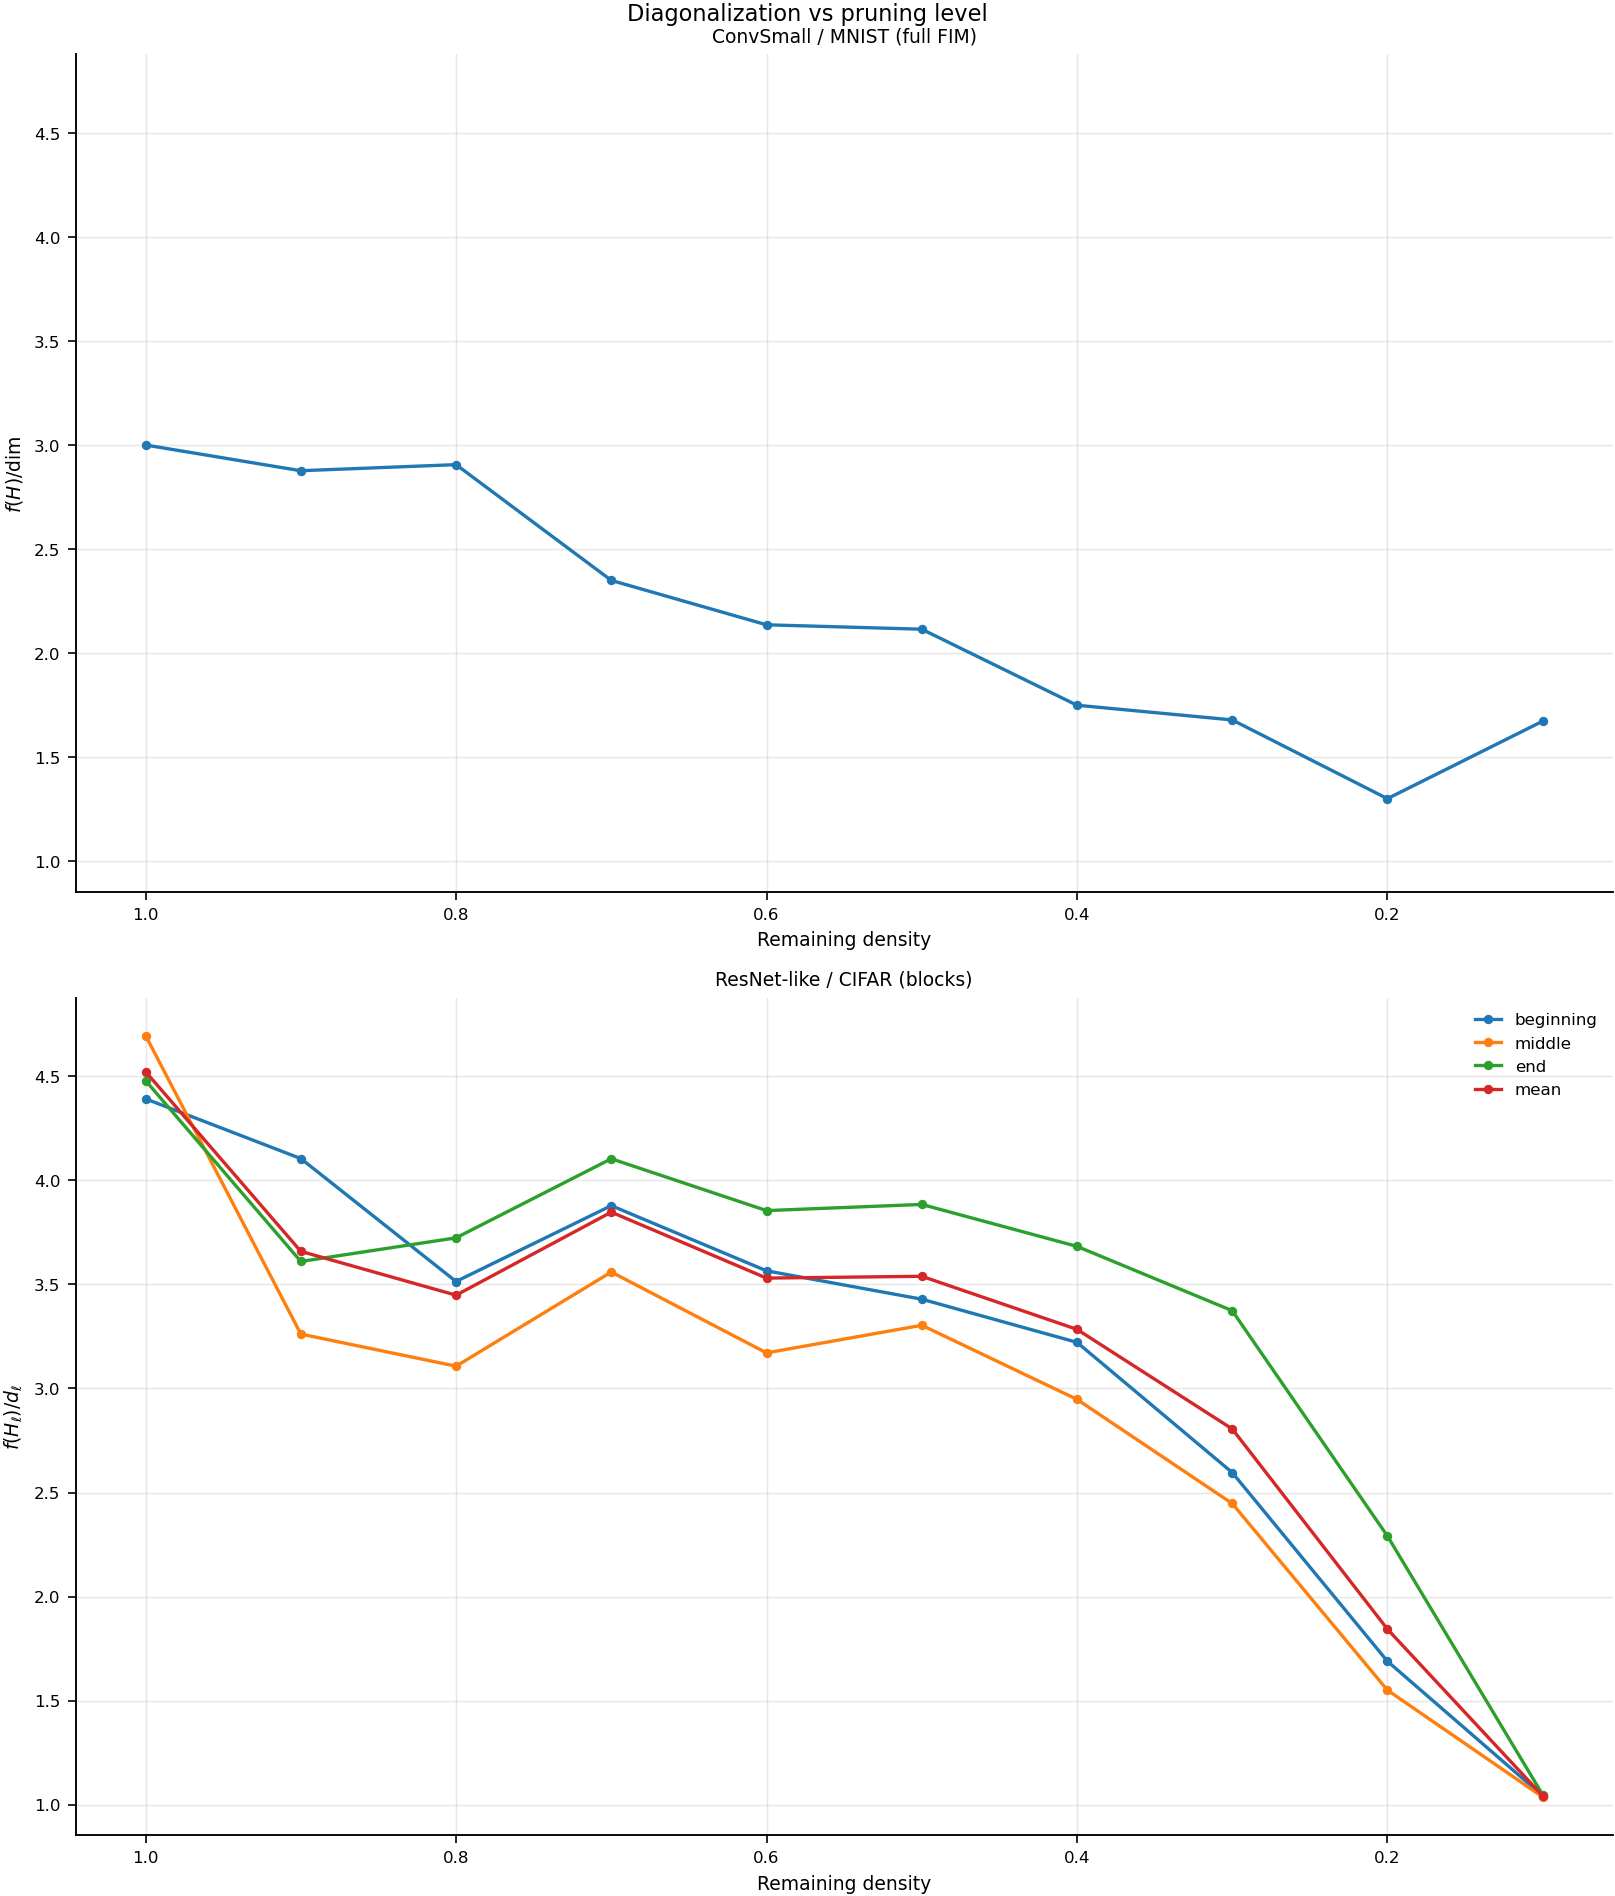

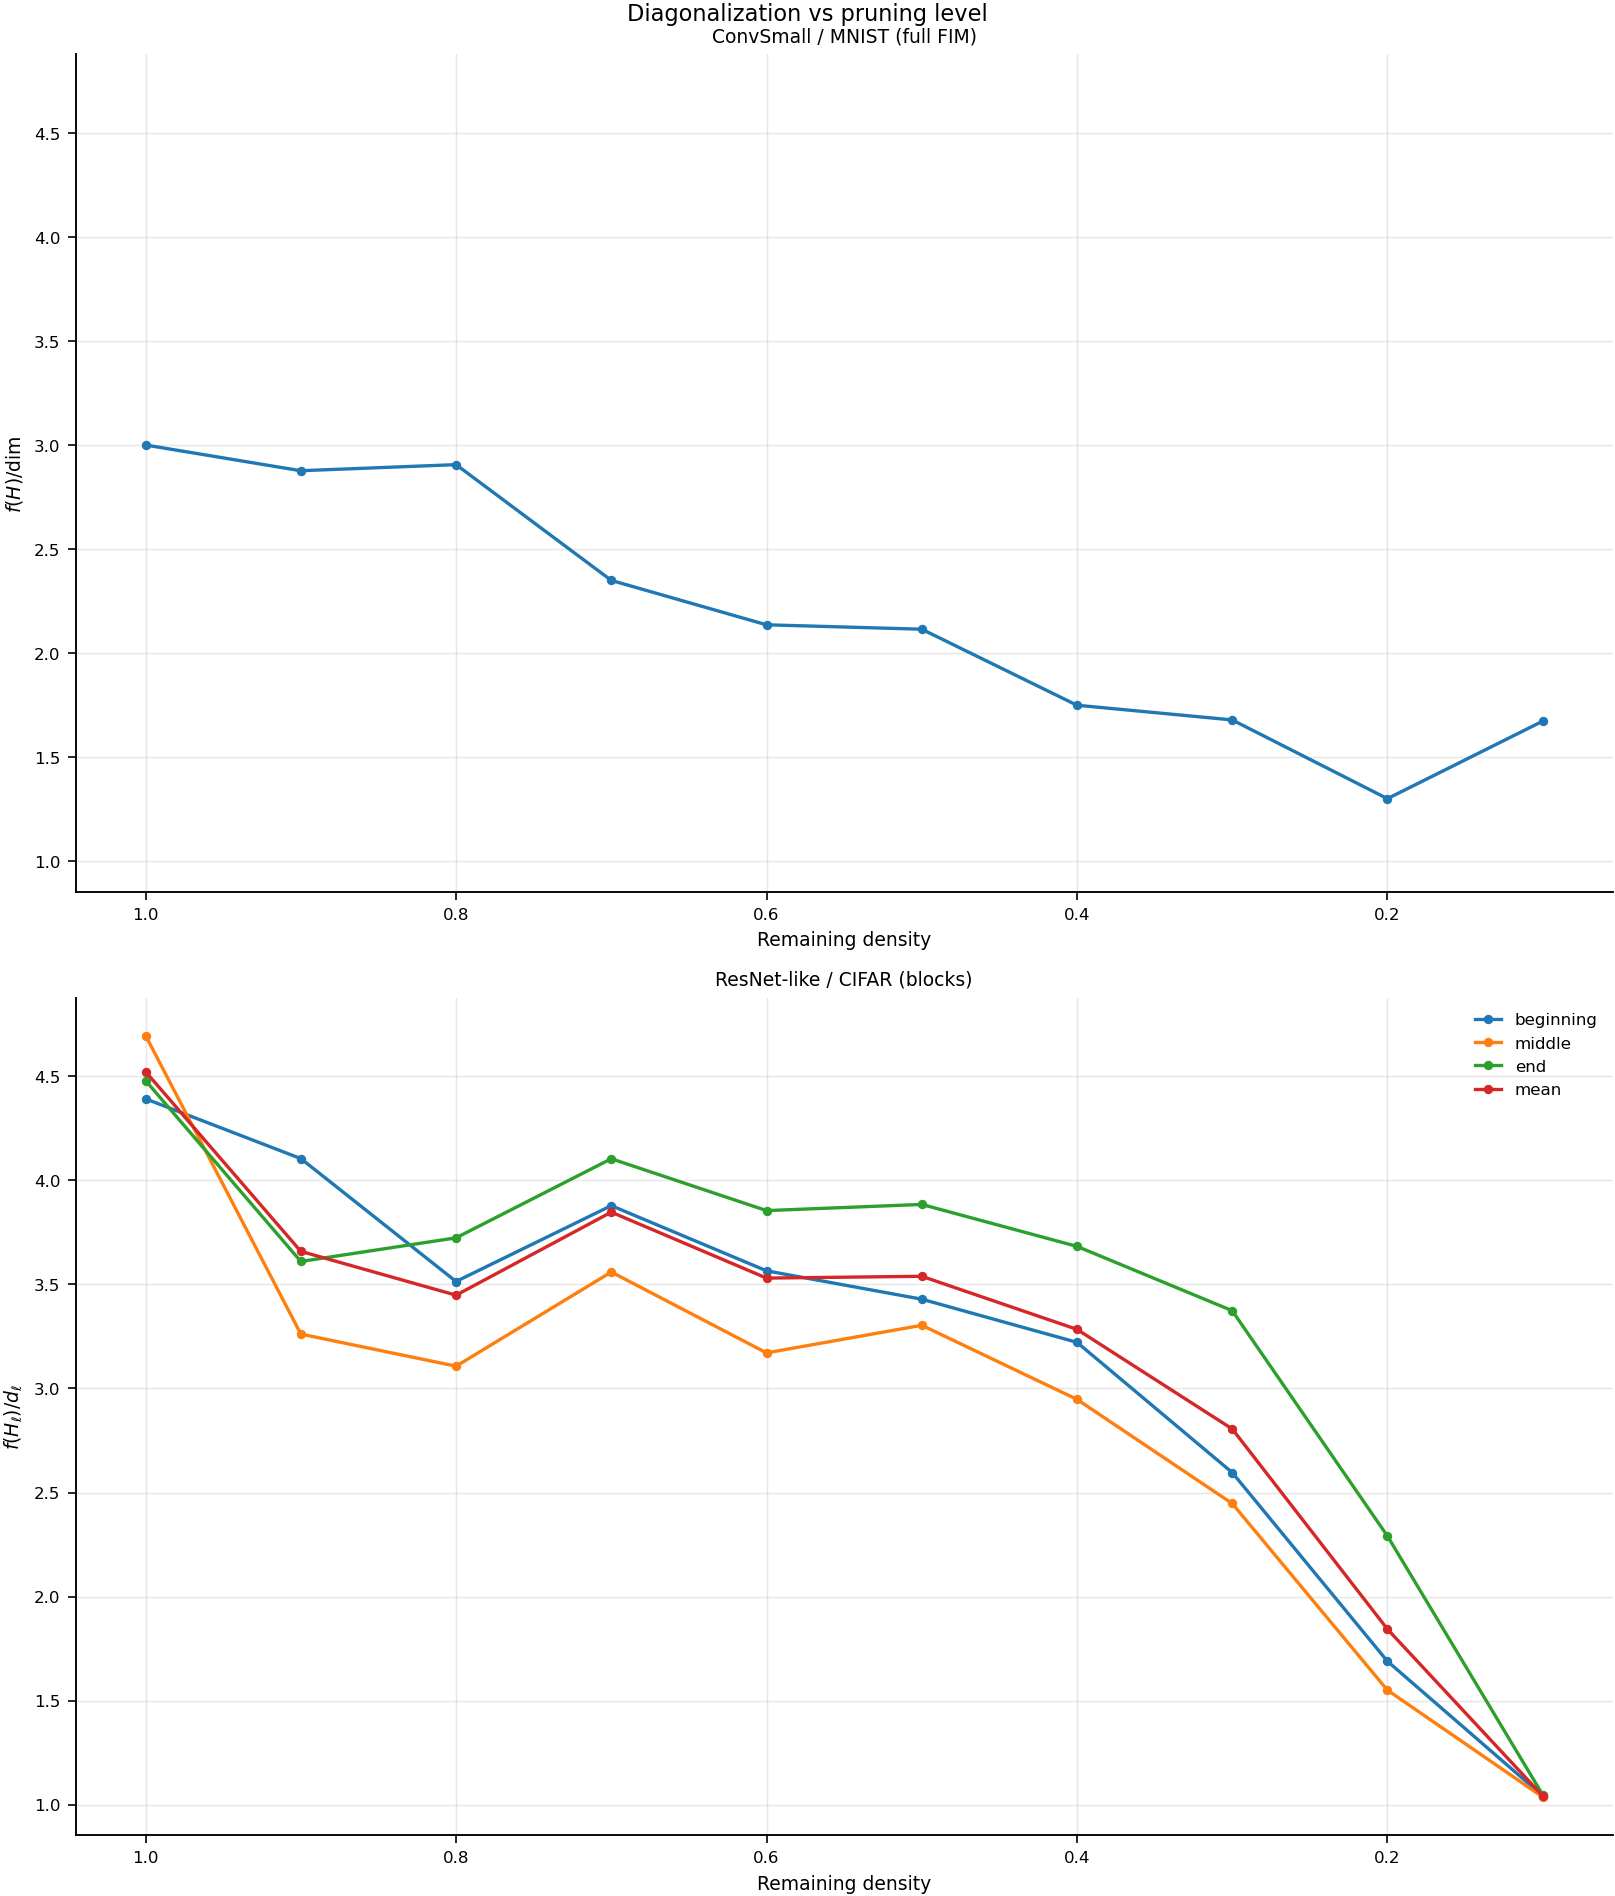

In [60]:
diag_curves = make_curves_from_layer_dict(CIFAR10_resnet_logdet_per_dim_dict, mode="bme", include_mean=True)
conv_diag_curves = make_curves_from_layer_dict(MNIST_logdet_per_dim_dict, mode="bme")

plot_two_panel(
        left=(dens, conv_diag_curves, "ConvSmall / MNIST (full FIM)", r"$f(H)/\mathrm{dim}$"),
        right=(dens, diag_curves, "ResNet-like / CIFAR (blocks)", r"$f(H_\ell)/d_\ell$"),
        figsize=(11,13),
        suptitle="Diagonalization vs pruning level",
        savepath='diag_vs_pruning.png'
    )

In [ ]:
if __name__ == "__main__":
    # Example input format like you showed (dict of lists)
    logdet_by_layer = {
        0: [4.39, 4.10, 3.51, 3.87],
        1: [4.53, 3.44, 2.98, 3.41],
        2: [4.69, 3.26, 3.10, 3.55],
    }
    cos_by_layer = {
        0: [0.50, 0.42, 0.33, 0.28],
        1: [0.48, 0.39, 0.30, 0.25],
        2: [0.46, 0.37, 0.29, 0.24],
    }

    T = validate_same_length_across_layers(logdet_by_layer)
    dens = densities_from_len(T, step=0.1)

    # For big models: 3 curves (beginning/middle/end)
    diag_curves = make_curves_from_layer_dict(logdet_by_layer, mode="bme", include_mean=True)
    cos_curves = make_curves_from_layer_dict(cos_by_layer, mode="bme", include_mean=True)

    # For ConvSmall full FIM: you likely have a dict with ONE key
    convsmall_full_logdet = {0: [2.1, 1.8, 1.4, 1.2]}
    convsmall_full_cos = {0: [0.40, 0.33, 0.26, 0.22]}
    conv_diag_curves = make_curves_from_layer_dict(convsmall_full_logdet, mode="bme")  # becomes {"full": [...]}
    conv_cos_curves = make_curves_from_layer_dict(convsmall_full_cos, mode="bme")

    # --- Main paper two-panel diagonalization
    plot_two_panel(
        left=(dens, conv_diag_curves, "ConvSmall / MNIST (full FIM)", r"$f(H)/\mathrm{dim}$"),
        right=(dens, diag_curves, "ResNet-like / CIFAR (blocks)", r"$f(H_\ell)/d_\ell$"),
        suptitle="Diagonalization vs pruning level",
    )

    # --- Main paper two-panel cosine
    plot_two_panel(
        left=(dens, conv_cos_curves, "ConvSmall / MNIST", "Cosine distance (NGD vs Adam)"),
        right=(dens, cos_curves, "ResNet-like / CIFAR", "Cosine distance (NGD vs Adam)"),
        suptitle="Adam vs NGD alignment vs pruning level",
    )

    # --- Scatter (bridge figure)
    points = []
    points += make_scatter_points_from_curves(conv_diag_curves, conv_cos_curves, group="ConvSmall-MNIST")
    points += make_scatter_points_from_curves(diag_curves, cos_curves, group="BigModel-CIFAR")

    fig, ax = plt.subplots(figsize=(5, 4))
    plot_alignment_scatter(points, legend_by="group", ax=ax)
    fig.tight_layout()

    plt.show()